The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


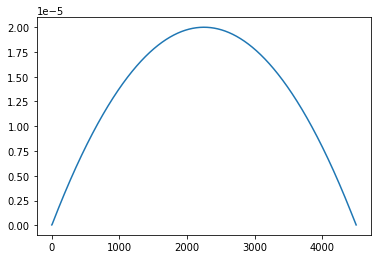

In [116]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from lens_simulation import utils
from lens_simulation.Lens import Lens
from lens_simulation.Medium import Medium
import numpy as np

       
# create lens
lens = Lens(diameter=4500e-6, 
            height=20e-6, 
            exponent=2.0, 
            medium=Medium(1))
lens.generate_profile(1e-6)


# plot lens
plt.plot(lens.profile)
plt.show()

SHAPE:  (10000, 4501)


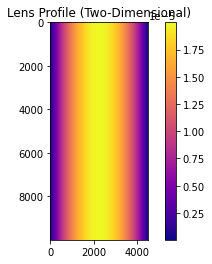

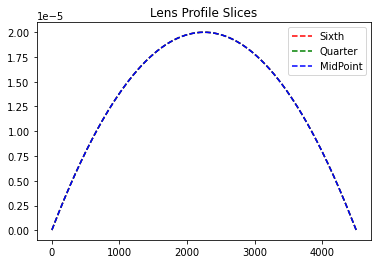

In [70]:
# exxtrude lens

lens.extrude_profile(length=10000e-6)

print("SHAPE: ", lens.profile.shape)

fig = utils.plot_lens_profile_2D(lens)

plt.show()

fig = utils.plot_lens_profile_slices(lens)
plt.show()



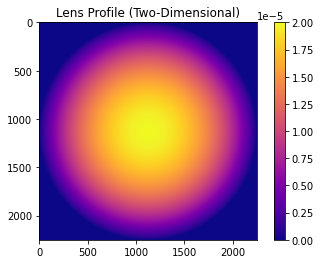

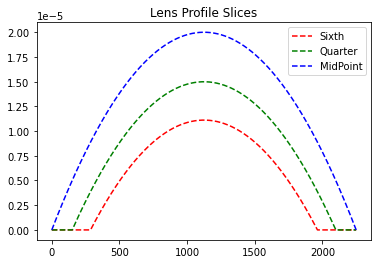

In [99]:
# revolve lens
lens.revolve_profile()

fig = utils.plot_lens_profile_2D(lens)

plt.show()

fig = utils.plot_lens_profile_slices(lens)
plt.show()


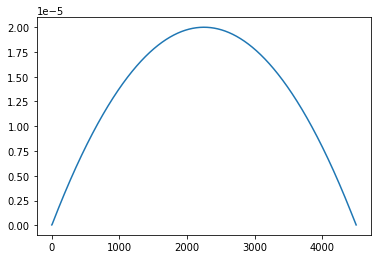

Lens Profile Shape:  (5000, 4501)
Sim Profile Shape:  (5000, 13503)


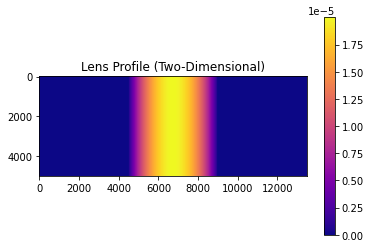

In [118]:
# padding
from lens_simulation.Simulation import pad_simulation

# create lens
lens = Lens(diameter=4500e-6, 
            height=20e-6, 
            exponent=2.0, 
            medium=Medium(1))
lens.generate_profile(1e-6)


# plot lens
plt.plot(lens.profile)
plt.show()

lens.extrude_profile(5000e-6)
# lens.revolve_profile()

sim_profile = pad_simulation(lens)

print("Lens Profile Shape: ", lens.profile.shape)
print("Sim Profile Shape: ", sim_profile.shape)

fig = utils.plot_lens_profile_2D(sim_profile)
plt.show()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1001,)


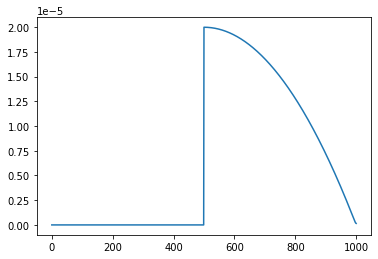

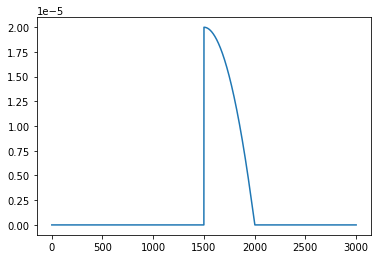

In [25]:
%load_ext autoreload
%autoreload 2
from lens_simulation import Simulation, structures, Lens



import uuid
import os
import yaml

with open("config.yaml", "r") as f:
    conf = yaml.full_load(f)

run_id = uuid.uuid4()  # run_id is for when running a batch of sims, each sim has unique id
data_path = os.path.join(os.getcwd() , "log",  str(run_id))
config = {"run_id": run_id, "parameters": None, "log_dir": data_path, 
            "sim_parameters": conf["sim_parameters"], "options": conf["options"],
            "mediums": conf["mediums"], "lenses": conf["lenses"],
            "stages": conf["stages"]}


sim = Simulation.Simulation(config)

lens = Lens.Lens(diameter=1000e-6, height=20e-6, exponent=2.0, medium=Lens.Medium(2.438))
lens.generate_profile(config["sim_parameters"]["pixel_size"])
lens.profile[0:lens.profile.shape[0] // 2] = 0


print(lens.profile.shape)

sim_stage = structures.SimulationStage(
    lens=lens,
    output=Lens.Medium(1.33), 
    n_slices=100,
    start_distance=0e-3,
    finish_distance=10e-3,
    options={},
)


sim_out, prop = sim.propagate_wavefront(sim_stage)



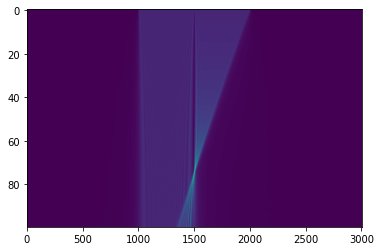

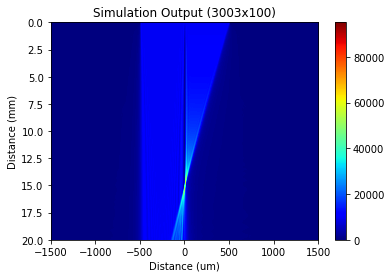

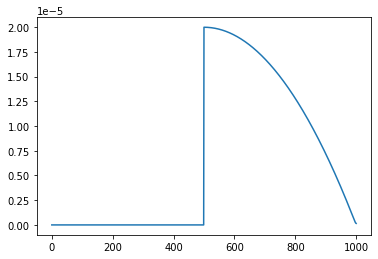

In [32]:
from lens_simulation.utils import plot_simulation

import matplotlib.pyplot  as plt

plt.imshow(sim_out[:, 0, :], aspect="auto")
plt.show()

# plot sim result
if sim_out.ndim == 3:
    width = sim_out.shape[2]
    height = sim_out.shape[0]
elif sim_out.ndim == 2:
    width = sim_out.shape[1]
    height = sim_out.shape[0]
else:
    raise ValueError(f"Simulation of {sim_out.ndim} is not supported")

fig = plot_simulation(
    sim_out,
    width,
    height,
    config["sim_parameters"]["pixel_size"],
    0,
    20e-3,
)

plt.show()

plt.plot(lens.profile)
plt.show()

0.0021855144404332133


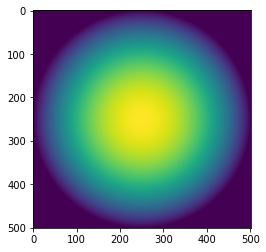

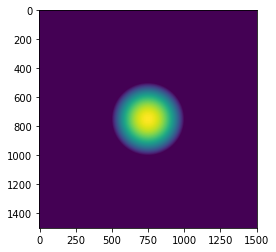

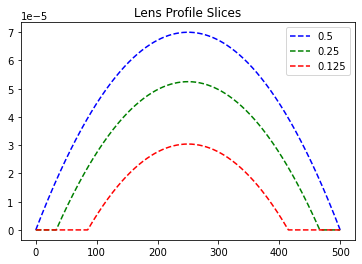

In [46]:
# create lens
from lens_simulation.Lens import Lens, Medium
lens = Lens(diameter=1000e-6, 
            height=70e-6, 
            exponent=2.0, 
            medium=Medium(2.438))
lens.generate_profile(1e-6)


# symmetric padding for revolve
lens.revolve_profile()
sim_profile = Simulation.pad_simulation(lens, pad_px=(lens.profile.shape))

eq_fd = Simulation.calculate_equivalent_focal_distance(
    lens, Medium(1.33)
)
print(eq_fd)

plt.imshow(lens.profile)
plt.show()

plt.imshow(sim_profile)
plt.show()

from lens_simulation import utils

utils.plot_lens_profile_slices(lens)
plt.show()


### 3D Visualisation


In [2]:
from lens_simulation import Simulation, utils, Lens, Medium
import matplotlib.pyplot as plt

import PIL

path = r"log\kindly-new-doe\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\1"
fname = os.path.join(path, "sim.npy")
sim = utils.load_simulation(fname)


print(sim.shape)



(10, 7506, 7506)


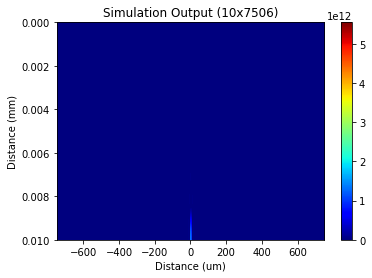

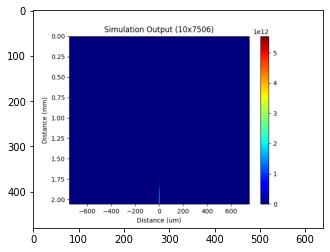

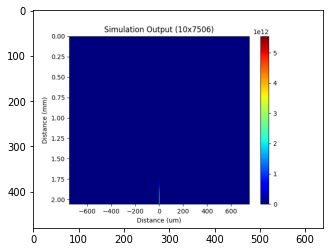

In [3]:
# plot 2D slice
fig = utils.plot_simulation(sim, pixel_size_x=200e-9)
plt.show()
plt.close(fig)


img_fname = os.path.join(path, "topdown.png")
# log_fname = os.path.join(path, "log_topdown.png")
sideon_fname = os.path.join(path, "sideon.png")

img = PIL.Image.open(img_fname)
sideon_img = PIL.Image.open(sideon_fname)

plt.imshow(img)
plt.show()

plt.imshow(sideon_img)
plt.show()



(10, 494, 700)


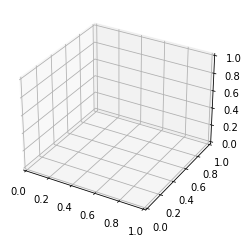

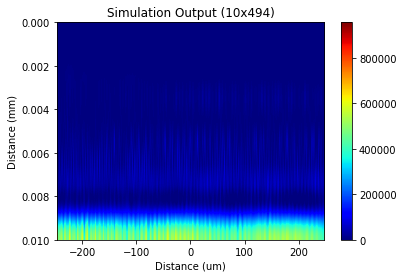

AttributeError: 'PathCollection' object has no property 'z'

In [7]:
# plot 3D volume

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


sim_resized = sim[:, -4000:4000, -700:]
print(sim_resized.shape)

utils.plot_simulation(sim_resized)
plt.show()

z, x, y = sim_resized.nonzero()
ax.scatter(xs=x, ys=y, z=z)


# drop padding
# convert to uint8
# resize the arr (interpolate)


# use proper 3D viz package
# pyramid data structure 


['log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\0.00000000mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\0.22827167mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\0.45654333mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\0.68481500mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\0.91308666mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\1.14135833mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\1.36962999mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\1.59790166mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\1.82617332mm.npy', 'log\\kindly-new-doe\\f9001ec1-d2ee-4c75-9af9-93c31f87ef2a\\1\\2.05444499mm.npy']
(7506, 7506)


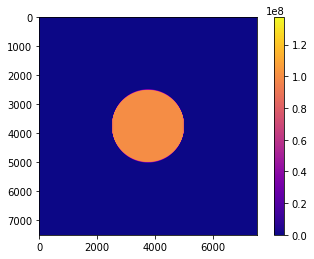

(7506, 7506)


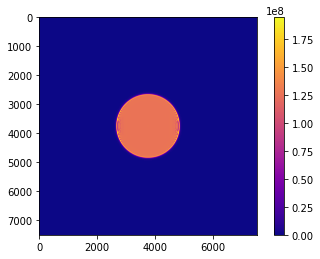

(7506, 7506)


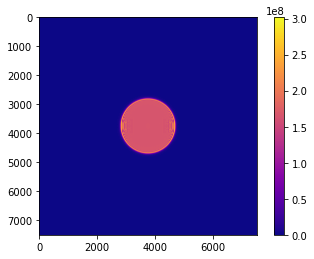

(7506, 7506)


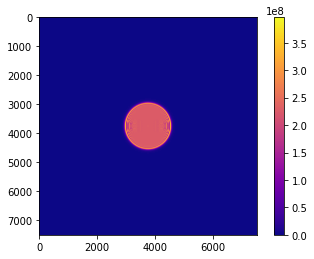

(7506, 7506)


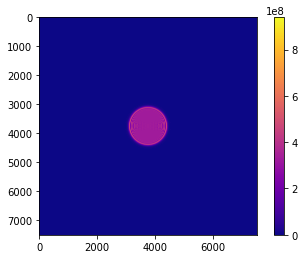

(7506, 7506)


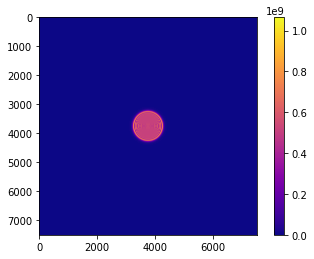

(7506, 7506)


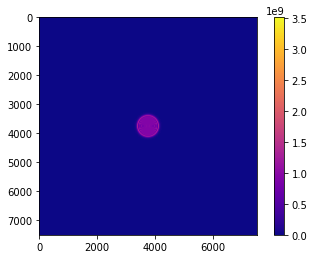

(7506, 7506)


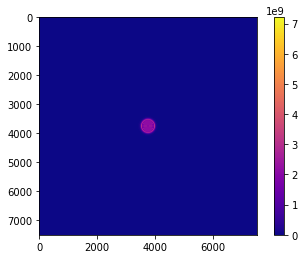

(7506, 7506)


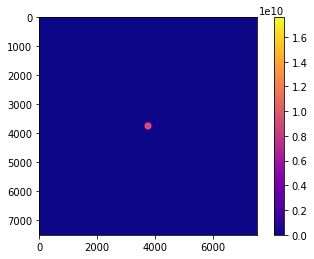

(7506, 7506)


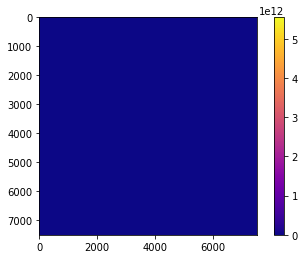

In [12]:
import glob


filenames = sorted(glob.glob(os.path.join(path, "*mm.npy")))

print(filenames)

for fname in filenames:
    layer = utils.load_simulation(fname)

    print(layer.shape)

    plt.imshow(layer, cmap="plasma")
    plt.colorbar()
    plt.show()